In [ ]:
!pip install imutils
!pip install wget
!pip install split-folders

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b9d39f163c85fc871bf8cf3e11ac74afd491cbece433cfecb1c899ee6d2fa8cd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# importing modules
import cv2
import numpy as np
import os
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

Закачка датасета

In [ ]:
# Манипуляции с колабом для скачки датасета с kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"trapofdifok","key":"b38d2a27527676cd444eb8eed59eacf4"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Aug 12 10:06 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
# Создаем директорию
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Устанавливаем разрешение к нашему json файлу
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Проверка рабочей директории
!pwd

/content


In [ ]:
# Скачиваем нужный датасет
!kaggle datasets download -d vinayakshanawad/meat-freshness-image-dataset

Dataset URL: https://www.kaggle.com/datasets/vinayakshanawad/meat-freshness-image-dataset
License(s): CC0-1.0
 99% 59.0M/59.4M [00:04<00:00, 21.7MB/s]
100% 59.4M/59.4M [00:04<00:00, 13.6MB/s]


In [ ]:
# Распаковка
!unzip meat-freshness-image-dataset.zip

Archive:  meat-freshness-image-dataset.zip
  inflating: Meat Freshness.v1-new-dataset.multiclass/README.dataset.txt  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1-_JPG.rf.65663691924ca0aede3884b863267c98.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-100-_JPG.rf.65e835ab6a2890785aade192d1e19549.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1000-_JPG.rf.d0f18a5c4075b50beeb7ee99036d491d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1003-_JPG.rf.b410c33a04a1fba90032a9086d191d6d.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1005-_JPG.rf.404839308dfdce0228de77bf7458513a.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-1009-_JPG.rf.1c4c304a072d95160d6ec26f0191344e.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/FRESH-101-_JPG.rf.4c18cd9fd197ac72fa9dd68fcd00502f.jpg  
  inflating: Meat Freshness.v1-new-dataset.multiclass/train/F

In [ ]:
file_name = os.listdir('Meat Freshness.v1-new-dataset.multiclass/train/')
names = [i.split('-')[0] for i in file_name]
set(names)

{'FRESH', 'HALF', 'SPOILED', '_classes.csv'}

In [ ]:
# Кодируем имена классов
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}

In [ ]:
train_x = []
train_y = []
test_x = []
test_y = []

In [ ]:
train_dir = 'Meat Freshness.v1-new-dataset.multiclass/train/'

for file_name in os.listdir(train_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(train_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(class_label_encoding[class_name])

In [ ]:
import os
import shutil

In [ ]:
output_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/'

# Создание директорий
class_dirs = {
    'FRESH': os.path.join(output_dir, 'Fresh'),
    'HALF': os.path.join(output_dir, 'Half-Fresh'),
    'SPOILED': os.path.join(output_dir, 'Spoiled')
}

for class_dir in class_dirs.values():
    os.makedirs(class_dir, exist_ok=True)

# Копирование файлов в соответствующие директории
for file_name in os.listdir(train_dir):
    class_name = file_name.split('-')[0]
    if class_name not in class_dirs:
        continue

    src_path = os.path.join(train_dir, file_name)
    dest_path = os.path.join(class_dirs[class_name], file_name)
    shutil.copy(src_path, dest_path)

print("Файлы успешно скопированы в соответствующие директории.")

Файлы успешно скопированы в соответствующие директории.


In [ ]:
fresh_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/Fresh/'
for file_name in os.listdir(fresh_dir):
    img = cv2.imread(fresh_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(2)

In [ ]:
half_dir = 'Meat Freshness.v1-new-dataset.multiclass/train_sorted/Half-Fresh/'
for file_name in os.listdir(half_dir):
    img = cv2.imread(half_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(2)

In [ ]:
spoiled_dir ='Meat Freshness.v1-new-dataset.multiclass/train_sorted/Spoiled/'
for file_name in os.listdir(spoiled_dir):
    img = cv2.imread(spoiled_dir+file_name).astype('float32') # read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    train_x.append(img)
    train_y.append(0)

In [ ]:
val_dir = 'Meat Freshness.v1-new-dataset.multiclass/valid/'

for file_name in os.listdir(val_dir):
    class_name = file_name.split('-')[0]
    if(class_name == '_classes.csv'): continue # ignore the csv file
    img = cv2.imread(val_dir+file_name).astype('float32') # read the colour image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to rgb format
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) # resize the image
    img /= 255. # normalising pixel values
    test_x.append(img)
    test_y.append(class_label_encoding[class_name])

In [ ]:
print('shape of train x:', end=' ')
print(np.asarray(train_x).shape)
print('len of train y: '+ str(len(train_y)))

print('shape of test x:', end=' ')
print(np.asarray(test_x).shape)

print('len of test y: '+ str(len(test_y)))

shape of train x: (3630, 128, 128, 3)
len of train y: 3630
shape of test x: (451, 128, 128, 3)
len of test y: 451


In [ ]:
# let's look at the class distribution
print('Train distribution')
print(pd.Series(train_y).value_counts())

print('Test distribution')
print(pd.Series(test_y).value_counts())

Train distribution
2    1980
0    1020
1     630
Name: count, dtype: int64
Test distribution
2    178
1    159
0    114
Name: count, dtype: int64


In [ ]:
# performing train test split with stratify enabled to maintain the class distribution
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.3, random_state=42, stratify=train_y)

# free up memory
del train_x
del train_y

In [ ]:
# performing one hot encoding and concerting list to numpy array before training
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3))) # each image shape - 416x416x3
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,'softmax')) # 3 classes

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      55,116,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,312,515 (211.00 MB)

 Trainable params: 55,312,515 (211.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# perform data augmentation
data_generator = ImageDataGenerator(rotation_range=15, zoom_range=0.1, vertical_flip=True, width_shift_range=0.1, height_shift_range=0.1)

In [ ]:
history = model.fit(data_generator.flow(x_train,y_train,batch_size=128),validation_data=data_generator.flow(x_val, y_val, batch_size=32),epochs=50,callbacks=[EarlyStopping(patience=8,restore_best_weights=True)])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4319 - loss: 1.5515 - val_accuracy: 0.5455 - val_loss: 0.9750
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 919ms/step - accuracy: 0.5699 - loss: 0.9582 - val_accuracy: 0.7025 - val_loss: 0.8128
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 685ms/step - accuracy: 0.7010 - loss: 0.7824 - val_accuracy: 0.7640 - val_loss: 0.6017
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 638ms/step - accuracy: 0.7464 - loss: 0.6457 - val_accuracy: 0.7603 - val_loss: 0.5656
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 714ms/step - accuracy: 0.7737 - loss: 0.5327 - val_accuracy: 0.8053 - val_loss: 0.4409
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step - accuracy: 0.7890 - loss: 0.5066 - val_accuracy: 0.8072 - val_loss: 0.4225
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 747ms/step - accuracy: 0.7850 - loss: 0.4646 - val_accuracy: 0.8090 - val_loss: 0.4025
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - accuracy: 0.7942 - loss: 0.4325 - val_accuracy: 0.8072 -

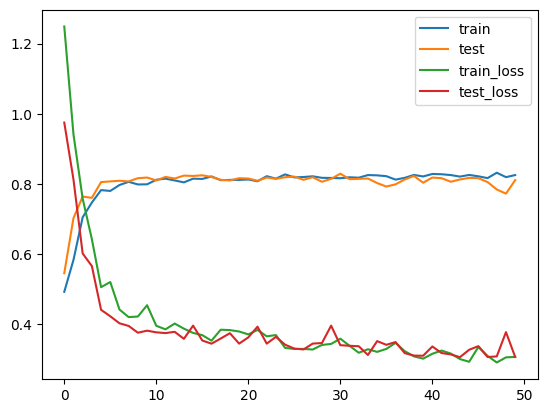

In [ ]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

In [ ]:
loss, acc = model.evaluate(np.array(test_x), to_categorical(test_y))
print('Testing accuracy on unseen data:', round(acc*100,3))
print('Testing loss on unseen data:', round(loss,3))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7051 - loss: 0.3470
Testing accuracy on unseen data: 70.51
Testing loss on unseen data: 0.359


In [ ]:
model.save('trained_model_10_epochs.h5')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 107648)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      55,116,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,937,547 (633.00 MB)

 Trainable params: 55,312,515 (211.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,625,032 (422.00 MB)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
test_x1 = np.array(test_x)
print(test_x1.shape)

(451, 128, 128, 3)


In [ ]:
test_gen = data_generator.flow(test_x1, test_y, batch_size=32)

In [ ]:
y_pred = model.predict(test_gen)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_y,toClass(y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


In [ ]:
print(cm)

[[ 27   7  80]
 [ 43   5 111]
 [ 46   9 123]]


In [ ]:
import matplotlib.pyplot as plt

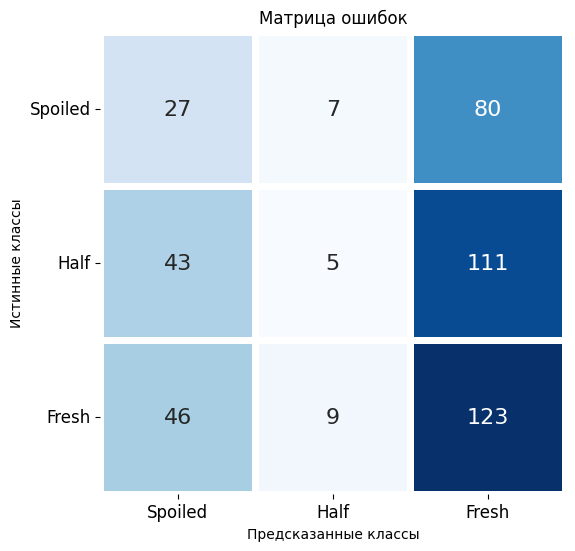

In [ ]:
df1 = pd.DataFrame(columns=["Spoiled","Half","Fresh"], index= ["Spoiled","Half","Fresh"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Blues", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Предсказанные классы")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок", size = 12)
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Получаем предсказания
y_pred_probs = model.predict(np.array(test_x))
y_pred = np.argmax(y_pred_probs, axis=1)

# Преобразуем test_y в метки классов, если это необходимо
y_test = np.array(test_y)

# Вычисляем F1-оценку
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
F1 Score: 0.6385


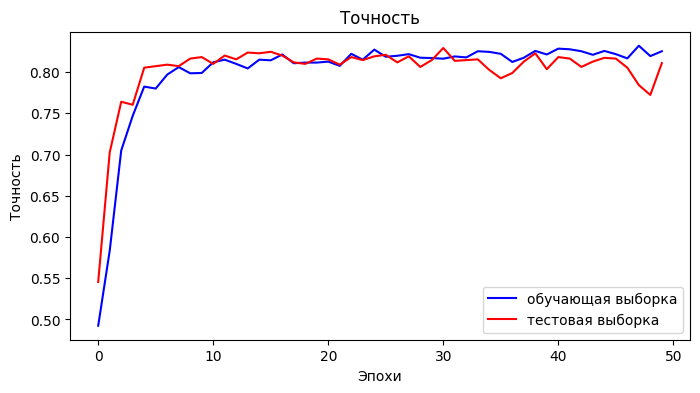

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))
plt.figure(figsize=(8,4))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Точность')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend(['обучающая выборка', 'тестовая выборка'], loc='lower right')

Text(0.5, 0, 'Эпохи')

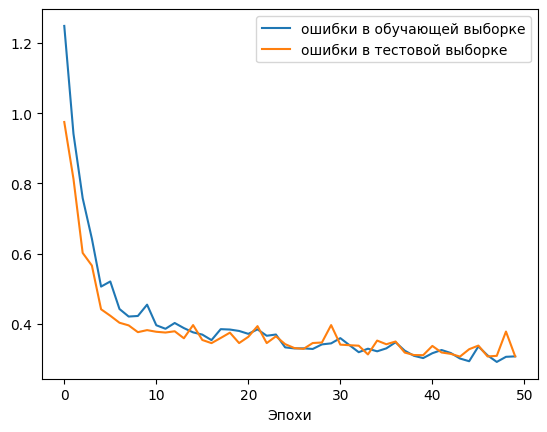

In [ ]:
pyplot.plot(history.history['loss'], label='ошибки в обучающей выборке')
pyplot.plot(history.history['val_loss'], label='ошибки в тестовой выборке')
pyplot.legend()
plt.xlabel('Эпохи')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


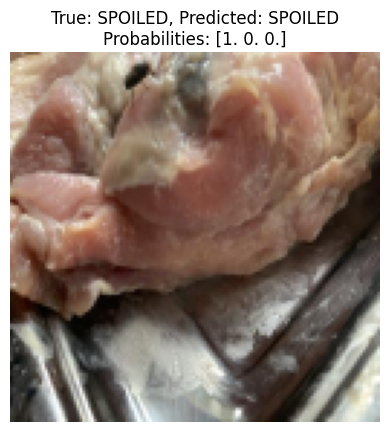

In [ ]:
# Функция для отображения изображения с предсказанием и истинным классом

def display_prediction(image, true_label, predicted_label, predicted_probs):
    # Округляем вероятности до двух знаков после запятой
    predicted_probs = np.round(predicted_probs, 2)
    plt.imshow(image)
    plt.title(f'True: {true_label}, Predicted: {predicted_label}\nProbabilities: {predicted_probs}')
    plt.axis('off')
    plt.show()

# Получаем случайный индекс
random_idx = np.random.randint(0, len(test_x))

# Извлекаем случайное изображение и его истинный класс
random_image = test_x[random_idx]
true_label = test_y[random_idx]

# Добавляем ось для батча и делаем предсказание
random_image_batch = np.expand_dims(random_image, axis=0)
predicted_probs = model.predict(random_image_batch)
predicted_label = np.argmax(predicted_probs, axis=1)[0]

# Маппинг числовых меток классов на текстовые метки
label_mapping = {0: 'SPOILED', 1: 'HALF', 2: 'FRESH'}
true_label_text = label_mapping[true_label]
predicted_label_text = label_mapping[predicted_label]

# Отображаем изображение с предсказанием
display_prediction(random_image, true_label_text, predicted_label_text, predicted_probs[0])